[Project Proposal](https://docs.google.com/document/d/1otqTXQpy0auO99Uk386XXw5Y3WP2ZkVFEbFu2N21PfU/edit?usp=sharing)

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras_tuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from keras_tuner.engine.hyperparameters import HyperParameters

# Mounting Dataset

[CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data)

In [3]:
synthetic_images_dataset = 'synthetic_images_dataset'

In [4]:
train_directory = os.path.join(synthetic_images_dataset, 'train')
test_directory = os.path.join(synthetic_images_dataset, 'test')

In [5]:
train_real = os.path.join(train_directory, 'REAL')
train_fake = os.path.join(train_directory, 'FAKE')

In [6]:
test_real = os.path.join(test_directory, 'REAL')
test_fake = os.path.join(test_directory, 'FAKE')

In [7]:
filepaths = {
    'training directory': train_directory,
    'testing_directory': test_directory,
    'training_real': train_real,
    'training_fake': train_fake,
    'testing_real': test_real,
    'testing_fake': test_fake
}

In [8]:
for label, filepath in filepaths.items():
  if not os.path.exists(filepath):
    print(f"The file path '{filepath}' DOES NOT exist.")
  else:
    print(f"The file path '{filepath}' DOES exist.")

The file path 'synthetic_images_dataset\train' DOES exist.
The file path 'synthetic_images_dataset\test' DOES exist.
The file path 'synthetic_images_dataset\train\REAL' DOES exist.
The file path 'synthetic_images_dataset\train\FAKE' DOES exist.
The file path 'synthetic_images_dataset\test\REAL' DOES exist.
The file path 'synthetic_images_dataset\test\FAKE' DOES exist.


# Data Analysis

In [9]:
def display_random_image(directory: str):
  image = random.choice(os.listdir(directory))
  jpg_image_path = os.path.join(directory, image)
  jpg_image = Image.open(jpg_image_path)

  print(f"Path: {jpg_image_path}")
  print(f"Size: {jpg_image.size}")
  print(f"Number of Channels: {jpg_image.mode}")
  print('')

  fig, ax = plt.subplots(1, 1, figsize=(1, 1))
  ax.imshow(jpg_image, interpolation='nearest')
  ax.axis("off")
  plt.show()

Training

In [10]:
print(f"Size of Training Dataset (REAL): {len(os.listdir(train_real))}")
print(f"Size of Training Dataset (FAKE): {len(os.listdir(train_fake))}")

Size of Training Dataset (REAL): 50000
Size of Training Dataset (FAKE): 50000


Path: synthetic_images_dataset\train\REAL\0991 (4).jpg
Size: (32, 32)
Number of Channels: RGB



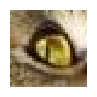

In [11]:
display_random_image(train_real)

Path: synthetic_images_dataset\train\FAKE\3159 (10).jpg
Size: (32, 32)
Number of Channels: RGB



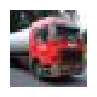

In [12]:
display_random_image(train_fake)

Testing

In [13]:
print(f"Size of Testing Dataset (REAL): {len(os.listdir(test_real))}")
print(f"Size of Testing Dataset (FAKE): {len(os.listdir(test_fake))}")

Size of Testing Dataset (REAL): 10000
Size of Testing Dataset (FAKE): 10000


Path: synthetic_images_dataset\test\REAL\0693 (7).jpg
Size: (32, 32)
Number of Channels: RGB



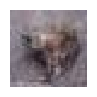

In [14]:
display_random_image(test_real)

Path: synthetic_images_dataset\test\FAKE\486 (9).jpg
Size: (32, 32)
Number of Channels: RGB



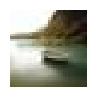

In [15]:
display_random_image(test_fake)

# Loading Dataset

In [16]:
train_dataset = keras.utils.image_dataset_from_directory(
    directory=train_directory,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(32, 32),
    validation_split=0.2,
    subset='training',
    seed=123)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.


In [17]:
validation_dataset = keras.utils.image_dataset_from_directory(
    directory=train_directory,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(32, 32),
    validation_split=0.2,
    subset='validation',
    seed=123)

Found 100000 files belonging to 2 classes.
Using 20000 files for validation.


In [18]:
testing_dataset = keras.utils.image_dataset_from_directory(
    directory=test_directory,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(32, 32))

Found 20000 files belonging to 2 classes.


# Training

In [19]:
def check_gpu_availability():
    if not tf.config.list_physical_devices('GPU'):
        raise RuntimeError("No GPU devices detected. TensorFlow cannot use GPU acceleration.")
    else:
        print("GPU is available and detected by TensorFlow.")

In [20]:
check_gpu_availability()

GPU is available and detected by TensorFlow.


In [21]:
def vgg16_model(input_shape=(32, 32, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten the output
    x = layers.Flatten()(x)

    # Fully connected layers
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs, outputs, name='vgg16')

    model.summary()
    return model

In [22]:
def train_model(model, train_dataset, validation_dataset, epochs=10):
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, verbose=1)

    # Evaluate the model
    loss, accuracy = model.evaluate(validation_dataset, verbose=0)
    print("Validation Accuracy:", accuracy)

    # Create dictionary for results
    results = {
        'accuracy': accuracy,
        'loss': loss,
        'history': history.history
    }

    return results

In [23]:
vgg16_model = vgg16_model()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0     

In [24]:
vgg16_results = train_model(vgg16_model, train_dataset, validation_dataset, epochs=10)

Epoch 1/10
2500/2500 [==============================] - 367s 141ms/step - loss: 0.4944 - accuracy: 0.8182 - val_loss: 0.5152 - val_accuracy: 0.8522
Epoch 2/10
2500/2500 [==============================] - 568s 227ms/step - loss: 0.3587 - accuracy: 0.8672 - val_loss: 0.2990 - val_accuracy: 0.8862
Epoch 3/10
2500/2500 [==============================] - 557s 223ms/step - loss: 0.2597 - accuracy: 0.9036 - val_loss: 0.2151 - val_accuracy: 0.9194
Epoch 4/10
2500/2500 [==============================] - 552s 220ms/step - loss: 0.2126 - accuracy: 0.9222 - val_loss: 0.4815 - val_accuracy: 0.8385
Epoch 5/10
2500/2500 [==============================] - 552s 221ms/step - loss: 0.1888 - accuracy: 0.9295 - val_loss: 0.1740 - val_accuracy: 0.9316
Epoch 6/10
2500/2500 [==============================] - 568s 227ms/step - loss: 0.1610 - accuracy: 0.9406 - val_loss: 0.1722 - val_accuracy: 0.9341
Epoch 7/10
2500/2500 [==============================] - 564s 226ms/step - loss: 0.1551 - accuracy: 0.9431 - val_

In [27]:
print('Training Results:', vgg16_results)

Training Results: {'accuracy': 0.9063000082969666, 'loss': 0.23270078003406525, 'history': {'loss': [0.4944099485874176, 0.35871049761772156, 0.25969457626342773, 0.21255119144916534, 0.1887897253036499, 0.16100752353668213, 0.15514253079891205, 0.13684198260307312, 0.1278468668460846, 0.11384689062833786], 'accuracy': [0.8181874752044678, 0.8671749830245972, 0.903612494468689, 0.9221875071525574, 0.9294624924659729, 0.9405999779701233, 0.9431124925613403, 0.9499750137329102, 0.9537875056266785, 0.9577875137329102], 'val_loss': [0.5151500105857849, 0.29900291562080383, 0.21510857343673706, 0.48148974776268005, 0.17397646605968475, 0.1722468137741089, 0.21845778822898865, 0.16422925889492035, 0.15123732388019562, 0.23270069062709808], 'val_accuracy': [0.852150022983551, 0.8861500024795532, 0.9194499850273132, 0.838450014591217, 0.9315999746322632, 0.9340500235557556, 0.9170500040054321, 0.9368500113487244, 0.9462500214576721, 0.9063000082969666]}}


In [28]:
test_loss, test_accuracy = vgg16_model.evaluate(testing_dataset)
print('Test Accuracy:', test_accuracy)

625/625 [==============================] - 12s 19ms/step - loss: 0.2212 - accuracy: 0.9096
Test Accuracy: 0.909600019454956


In [29]:
def save_model(model, model_file):
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_file}")

In [30]:
save_model(vgg16_model, "first_synth_vgg16_model.pkl")

INFO:tensorflow:Assets written to: ram://1427dfe2-3037-4989-a015-9e5321413bb9/assets


INFO:tensorflow:Assets written to: ram://1427dfe2-3037-4989-a015-9e5321413bb9/assets


Model saved to first_synth_vgg16_model.pkl
